In [1]:
import sys
import os
from utils import loadFSL, FSLeyesServer, mkdir_no_exist
loadFSL()
os.environ["DIPY_HOME"] = "../data/"
import fsl.wrappers, statsmodels
from fsl.wrappers import fslmaths
import dipy
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import subprocess
from copy import deepcopy

In [2]:
%gui wx

In [3]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()


(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:01:14.244: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:01:14.244: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:01:14.244: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:01:14.245: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


In [28]:
dataset_id = 'ds000171' 
subject_id = 'control01'    
sample_path = "./data/" 
os.makedirs(sample_path, exist_ok=True)
bids_root = op.join(sample_path, dataset_id)
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') 
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))
flirt_path = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))


In [5]:
target_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco_bbr_std_smoothed-6mm.nii')

In [6]:
from nilearn.image import concat_imgs, mean_img
fmri_img = nib.load(target_path)

In [7]:
events_files = sorted([f for f in os.listdir(op.join(bids_root, 'sub-control01', 'func')) if f.endswith('.tsv') and "task-music" in f])
events_list = [pd.read_csv(op.join(bids_root, 'sub-control01', 'func', f), sep='\t') for f in events_files]
# events = pd.concat(events_list, ignore_index=True)
events_list[0]

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [8]:
onset = 0.0
for df in events_list:
    df['onset'] = df['onset']+onset
    onset += df.iloc[-1]["onset"]

In [9]:
data = fmri_img.dataobj[...,:105]

target_img = nib.Nifti1Image(data,fmri_img.affine, fmri_img.header)


In [10]:
fsleyesDisplay.resetOverlays()
# fsleyesDisplay.load(target_img)

In [11]:
import json

# Load JSON data from a file
with open("./task-music_bold.json", 'r') as file:
    data = json.load(file)

TR = data['RepetitionTime']


(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:01:22.393: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:01:22.393: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:01:22.393: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:01:22.393: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


In [12]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=TR,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(target_img, events_list[0])

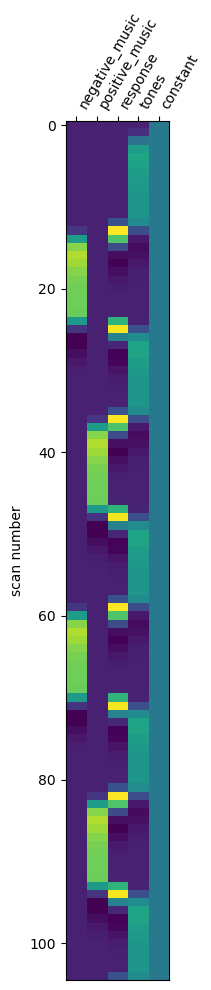

In [13]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [14]:
# Create the dictionary of the conditions
trial_type = ['positive_music', 'negative_music']

conditions = {
    trial_type[0]: np.array([0,1,0,0,0]),
    trial_type[1]:np.array([1,0,0,0,0])
}
active_minus_rest = conditions[trial_type[0]] - conditions[trial_type[1]]

<Axes: label='conditions'>

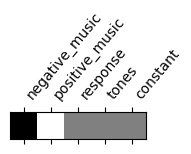

In [15]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=fmri_glm.design_matrices_[0])  ####TODO ADD COLOR SCALE

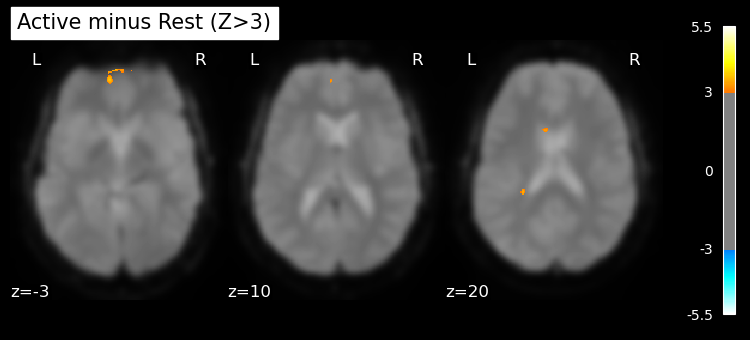

In [16]:
import nibabel as nib
z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(target_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=[-3,10,20], black_bg=True,
              title='Active minus Rest (Z>3)')
plt.show()

In [17]:
from nilearn.glm.first_level.design_matrix import _make_drift

column_values, column_names = _make_drift(drift_model='polynomial', frame_times=np.arange(0, target_img.dataobj.shape[-1])*int(TR), order=3, high_pass=None)

In [18]:
design_mat = fmri_glm.design_matrices_[0]
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col

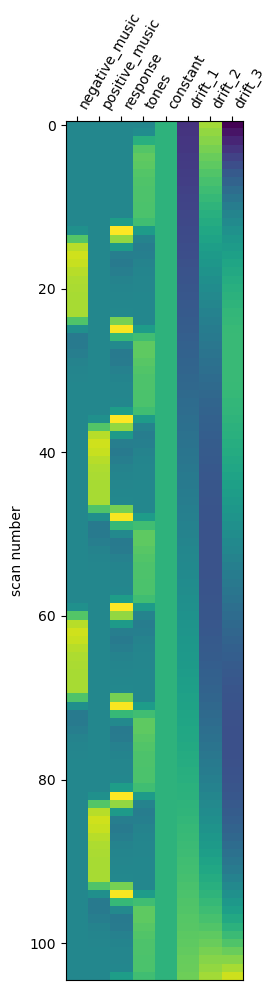

In [19]:
plot_design_matrix(design_mat)
plt.show()

In [20]:
import nibabel as nib
z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

In [21]:
nib.save(z_map, 'z_map_uncorrected.nii.gz')

In [33]:
import xml.etree.ElementTree as ET

def display_atlas_corresp(atlas_xml_path):
    """
    Given a path to an XML, extract all region labels and print their correspondance with numerical values
    of the nifti atlas file. (FSL-based convention)

    Parameters
    ----------
    atlas_xml_path: string
        Path to an XML atlas path, from which to extract all labels.
    """
    root=ET.parse(atlas_xml_path).getroot()
    for type_tag in root.findall('data/label'):
        value = type_tag.get('index')
        display('{} : {}'.format(int(value)+1, type_tag.text))

In [35]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(mni_template)
fsleyesDisplay.load(flirt_path)
fsleyesDisplay.load("z_map_uncorrected.nii.gz")
fsleyesDisplay.load(op.expandvars('$FSLDIR/data/atlases/MNI/MNI-maxprob-thr25-1mm.nii.gz'))
fsleyesDisplay.setOverlayCmap(3,'Render3')
display_atlas_corresp(op.expandvars('$FSLDIR/data/atlases/MNI.xml'))


(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 16:10:15.232: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 16:10:15.257: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 16:10:15.384: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 16:10:15.408: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 16:10:15.511: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 16:10:15.534: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 16:10:16.286: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)'

'1 : Caudate'

'2 : Cerebellum'

'3 : Frontal Lobe'

'4 : Insula'

'5 : Occipital Lobe'

'6 : Parietal Lobe'

'7 : Putamen'

'8 : Temporal Lobe'

'9 : Thalamus'


(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:10:17.267: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:10:17.267: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:10:17.267: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-WARNING **: 16:10:17.267: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 16:10:21.145: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 16:10:21.168: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:287324): Gtk-CRITICAL **: 

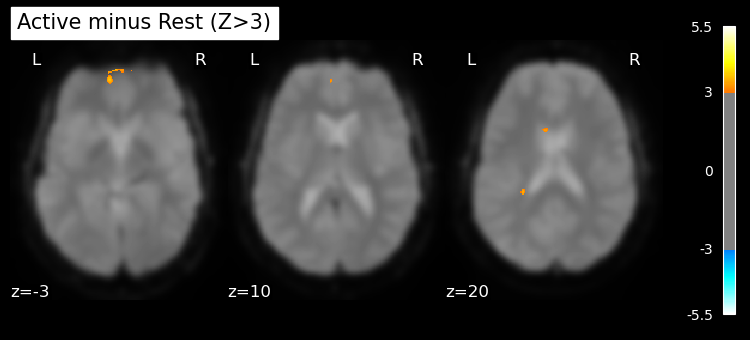

In [22]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(target_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=[-3,10,20], black_bg=True,
              title='Active minus Rest (Z>3)')
plt.show()

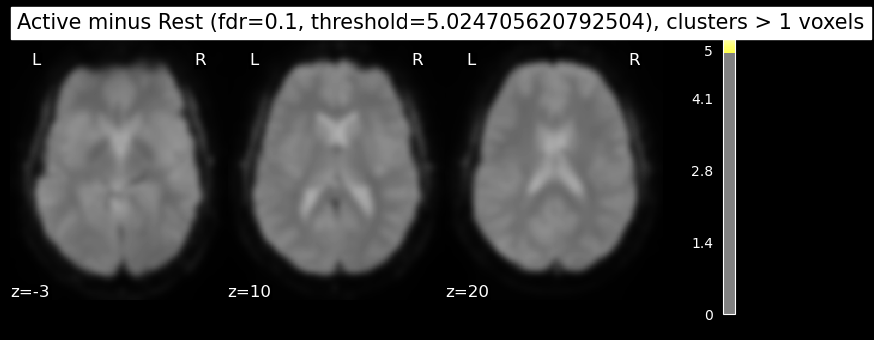

In [32]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 1 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.1 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-3,10,20], black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()